We want to visualize the distributional shifts between MIMIC-III and MIMIC-IV 

In [1]:
import sys
import getpass
user_id = getpass.getuser()
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import numpy as np
import os
import pandas as pd

2024-12-06 11:23:56.800722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 11:23:56.800772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 11:23:56.801800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 11:23:56.808109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 11:23:57.558948: W tensorflow/compiler/tf2

In [2]:
def custom_train_reps(source_features, target_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    In the cross database experiments, we run PCA separately on source and target, and use Gromov Wasserstein OT to enable transfer learning

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    source_reps = source_pca.fit_transform(source_features)

    # When using gromov Wasserstein OT, we can use different PCA to embed source and target features 
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = source_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return source_reps, target_reps

In [3]:
# Set parameters for this task
n_components = 50

suffix = None

group_name = 'version'
source = 'mimic_iv'
target = 'mimic_iii'

source_count = 10000
target_count = 10000

# trans_metric = 'OT'
trans_metric = 'GWOT'
output_dir = cross_output_dir
input_name = 'ICD codes'
output_name = 'duration'
type = 'cat'


In [4]:
# Read in dataframe
full_df = pd.read_csv(os.path.join(output_dir, "admission_patient_diagnosis_ICD.csv"), index_col=None, header=0, converters={'ICD codes': literal_eval})
selected_df = select_samples(full_df, group_name, type, source, target, source_count=source_count, target_count=target_count)

source_features, source_labels, target_features, target_labels = gen_code_feature_label(selected_df, group_name, type, source, target, input_name, output_name)

source_reps, target_reps = custom_train_reps(source_features, target_features, n_components)



enter this
number of target indices is: 58976 target_count is: 10000
number of source indices is: 545497 source_count is: 10000
number of codes is: 13152


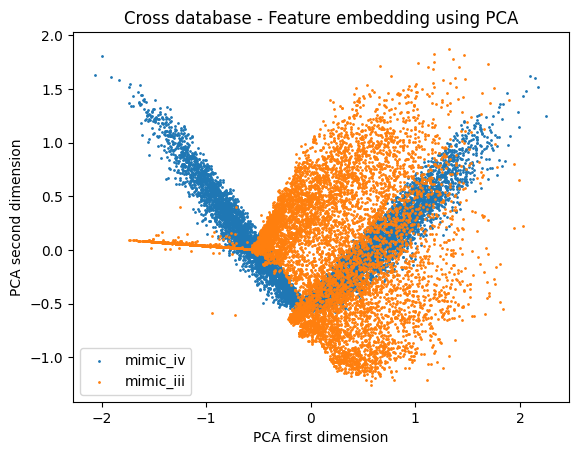

In [5]:
plt.scatter(source_reps[:, 0], source_reps[:, 1], label=source, s=1)
plt.scatter(target_reps[:, 0], target_reps[:, 1], label=target, s=1)
plt.xlabel('PCA first dimension')
plt.ylabel('PCA second dimension')
plt.title('Cross database - Feature embedding using PCA')
plt.legend()
plt.savefig(os.path.join(output_dir, f"{group_name}_distn_shift.pdf"))